In [1]:
%cd ..

/home/jupyter-tim/ba-tim


In [2]:
from drlqap.taskgenerators import generators, RandomWeightsTaskGenerator, RandomMatricesTaskGenerator, LinearTaskGenerator
import scipy.optimize
from drlqap.simplesolver import solve_qap_backtracking, solve_qap_maxgreedy, solve_qap_faq, solve_random
from drlqap.gurobi import solve_qap_gurobi
import numpy as np
from drlqap.qap import QAP
from drlqap.evaltools import load_checkpoints
from pathlib import Path
import random
import matplotlib.pyplot as plt

In [3]:
# Clears results
results = {}

In [81]:
agents = {}
agents["dqn_medium"] = load_checkpoints(Path('runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1'))
agents["dqn_small"] = load_checkpoints(Path('runs/dqn_dense_ms_ec_eps0_smallrandoms/lr5e-4_s1'))
agents["dqn_mini"] = load_checkpoints(Path('runs/dqn_dense_ms_ec_eps0_mini/lr5e-4_s1'))
agents["dqn_bi"] = load_checkpoints(Path('runs/dqn_bi_increasing/lr5e-4_s1'))
agents["a2c_inc"] = load_checkpoints(Path('runs/a2c_ms100x_increasing/lr8e-5_s1'))
agents["a2c_medium"] = load_checkpoints(Path('runs/a2c_ms100x_mediumrandoms/lr4e-5_s1'))
agents["a2c_small"] = load_checkpoints(Path('runs/a2c_ms100x_smallrandoms/lr4e-5_s2'))
agents["reinforce"] = load_checkpoints(Path('runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/'))
agents["dqn_tai35a"] = load_checkpoints(Path('runs/dqn_dense_ms_ec_tai35a/lr5e-4_s1/'))

runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_0.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_1000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_2000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_3000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_4000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_5000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_6000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_7000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_8000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_9000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_end.pth
runs/dqn_dense_ms_ec_eps0_smallrandoms/lr5e-4_s1/checkpoint_0.pth
runs/dqn_dense_ms_ec_eps0_smallrandoms/lr5e-4_s1/checkpoint_1000.pth
runs/dqn_dense_ms_ec_eps0_smallrandoms/lr5e-4_s1/checkpoint_2000.pth
runs/dqn_dense_ms_ec_eps0_smal

runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_6000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_7000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_8000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_9000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_10000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_11000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_12000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_13000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_14000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_15000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_16000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_17000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_18000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_19000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_20000.pth
runs/reinforce

In [5]:
def evaluate(solver, problem, samples):
    if type(problem) == str:
        generator = generators[problem]
    else:
        generator = problem
    qaps = [generator.sample() for i in range(samples)]
    return evaluate_set(solver, qaps)
    
def evaluate_set(solver, problems):
    values = []
    correct = 0
    for qap in problems:
        v_solver, assignment = solver(qap)
        v = qap.compute_value(assignment)
        if not np.isclose(v, v_solver):
            print (f"solver outputs incorrect value (got {v_solver}, actual {v})")
        values.append(v)
    mean = np.mean(values)
    print(f"mean: {mean}")
    return mean

In [6]:
problems = {}
problems["small"] = [RandomWeightsTaskGenerator(8).sample() for i in range(20)]
problems["medium"] = [RandomWeightsTaskGenerator(16).sample() for i in range(20)]
problems["large"] = [RandomWeightsTaskGenerator(32).sample() for i in range(20)]
problems["64"] = [RandomWeightsTaskGenerator(64).sample() for i in range(20)]
problems["128"] = [RandomWeightsTaskGenerator(128).sample() for i in range(20)]
problems["small_rm"] = [RandomMatricesTaskGenerator(8).sample() for i in range(20)]
problems["mini_lap"] = [LinearTaskGenerator(2).sample() for i in range(100)]

In [7]:
def sequence_evaluation(agents, problems):
    return [evaluate_set(agent.solve, problems) for agent in agents]

In [8]:
def evaluate_and_store(agent_name, problem_name):
    if (agent_name, problem_name) not in results:
        results[agent_name, problem_name] = sequence_evaluation(agents[agent_name], problems[problem_name])

# Computations

## n=32

In [54]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "dqn_mini"]:
    evaluate_and_store(agent_name, "large")

In [55]:
for agent_name in ["a2c_inc", "a2c_medium", "reinforce", "a2c_small"]:
    evaluate_and_store(agent_name, "large")

mean: 246.85086059570312
mean: 255.4828643798828
mean: 255.0658416748047
mean: 253.6199951171875
mean: 254.8418426513672
mean: 252.2252960205078
mean: 245.36111450195312
mean: 249.268798828125
mean: 242.3280487060547
mean: 239.6925506591797
mean: 234.08938598632812
mean: 232.3330535888672
mean: 233.04257202148438
mean: 234.06179809570312
mean: 233.2264862060547
mean: 234.4326934814453
mean: 232.543701171875
mean: 232.0605926513672
mean: 232.62216186523438
mean: 231.68496704101562
mean: 230.84371948242188
mean: 231.7961883544922
mean: 231.9616241455078
mean: 231.7730255126953
mean: 231.01626586914062
mean: 230.57028198242188
mean: 232.09951782226562
mean: 230.4901580810547
mean: 230.62484741210938
mean: 231.5851287841797
mean: 234.35610961914062
mean: 232.63699340820312
mean: 230.0967559814453
mean: 232.4412078857422
mean: 231.34616088867188
mean: 229.82931518554688
mean: 231.94973754882812
mean: 232.7682342529297
mean: 231.2563018798828
mean: 230.63790893554688
mean: 230.5428924560547


In [56]:
evaluate_set(solve_qap_faq, problems["large"])

mean: 210.3939971923828


210.394

## n=16

In [57]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "dqn_mini", "dqn_tai35a"]:
    evaluate_and_store(agent_name, "medium")

In [58]:
for agent_name in ["a2c_inc", "a2c_medium", "reinforce", "a2c_small"]:
    evaluate_and_store(agent_name, "medium")

mean: 59.78355026245117
mean: 63.063575744628906
mean: 62.335853576660156
mean: 62.25928497314453
mean: 62.383995056152344
mean: 62.15785598754883
mean: 60.07582473754883
mean: 60.847129821777344
mean: 58.00328826904297
mean: 55.31071853637695
mean: 53.802650451660156
mean: 53.87154006958008
mean: 53.94553756713867
mean: 54.04339599609375
mean: 53.62660598754883
mean: 53.07932662963867
mean: 53.786407470703125
mean: 53.34668731689453
mean: 53.61896896362305
mean: 52.86821365356445
mean: 53.0169792175293
mean: 52.327880859375
mean: 53.02356719970703
mean: 53.220191955566406
mean: 52.99312210083008
mean: 53.078216552734375
mean: 52.88928985595703
mean: 52.80022048950195
mean: 53.071983337402344
mean: 52.91740036010742
mean: 53.39544677734375
mean: 53.34838104248047
mean: 52.45526123046875
mean: 52.665733337402344
mean: 52.93574905395508
mean: 52.73036575317383
mean: 53.406333923339844
mean: 52.6070442199707
mean: 52.68799591064453
mean: 52.85445022583008
mean: 53.034324645996094


In [59]:
evaluate_set(solve_qap_faq, problems["medium"])

mean: 49.47801971435547


49.47802

## n=8

In [60]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "dqn_mini"]:
    evaluate_and_store(agent_name, "small")

In [72]:
for agent_name in ["a2c_inc", "a2c_medium", "reinforce", "a2c_small"]:
    evaluate_and_store(agent_name, "small")

In [62]:
evaluate_set(solve_qap_faq, problems["small"])

mean: 11.10856819152832


11.108568

In [63]:
evaluate_set(solve_qap_backtracking, problems["small"])

mean: 10.500444412231445


10.500444

In [64]:
evaluate_set(solve_random, problems["small"])

mean: 13.62640380859375


13.626404

## n=2 linear only

In [79]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "dqn_mini", "a2c_inc", "a2c_medium", "reinforce", "a2c_small"]:
    evaluate_and_store(agent_name, "mini_lap")

mean: 0.9404857754707336
mean: 1.0446237325668335
mean: 1.0093395709991455
mean: 0.9825831055641174
mean: 0.9698020219802856
mean: 1.01576566696167
mean: 1.054345965385437
mean: 1.1096794605255127
mean: 1.0518075227737427
mean: 1.0226125717163086
mean: 1.078721523284912
mean: 1.0037845373153687
mean: 1.0131696462631226
mean: 0.9656276106834412
mean: 0.9714969396591187
mean: 0.9670861959457397
mean: 0.9224900007247925
mean: 0.9297893643379211
mean: 0.9494903683662415
mean: 0.9238044619560242
mean: 0.8758109211921692
mean: 0.8666676878929138
mean: 0.9090551137924194
mean: 0.8765324354171753
mean: 0.9523599147796631
mean: 0.8866590261459351
mean: 0.9122161269187927
mean: 0.9166489243507385
mean: 0.911649763584137
mean: 0.8857423663139343
mean: 0.8736079931259155
mean: 0.8913298845291138
mean: 0.884868323802948
mean: 0.9137080907821655
mean: 0.8993391394615173
mean: 0.9220850467681885
mean: 0.881024181842804
mean: 0.88716721534729
mean: 0.8871504068374634
mean: 0.8995506167411804
mean: 0.9

# n=64

In [66]:
for agent_name in ["reinforce", "a2c_medium", "a2c_small"]:
    evaluate_and_store(agent_name, "64")

mean: 1010.1767578125
mean: 1024.6331787109375
mean: 1027.60107421875
mean: 1023.9736328125
mean: 1023.4168090820312
mean: 1020.6653442382812
mean: 995.1809692382812
mean: 1020.5984497070312
mean: 1006.7380981445312
mean: 999.9910888671875
mean: 982.3258666992188
mean: 977.4537963867188
mean: 982.79833984375
mean: 991.2160034179688
mean: 980.9625854492188
mean: 987.0675048828125
mean: 972.6602783203125
mean: 979.193359375
mean: 992.5792846679688
mean: 976.2833862304688
mean: 972.7769775390625
mean: 973.0194091796875
mean: 988.5685424804688
mean: 973.0328369140625
mean: 976.8193359375
mean: 982.5984497070312
mean: 985.9983520507812
mean: 971.1945190429688
mean: 975.9500732421875
mean: 986.33837890625
mean: 984.63232421875
mean: 973.2652587890625
mean: 981.3568115234375
mean: 977.0056762695312
mean: 971.4201049804688
mean: 977.0565185546875
mean: 979.9166259765625
mean: 979.1142578125
mean: 971.4851684570312
mean: 966.7777099609375
mean: 981.4051513671875


# n=128

In [67]:
for agent_name in ["reinforce", "a2c_medium", "a2c_small"]:
    evaluate_and_store(agent_name, "128")

mean: 4065.703125
mean: 4086.88671875
mean: 4094.12158203125
mean: 4076.989013671875
mean: 4085.093017578125
mean: 4082.396484375
mean: 4035.251953125
mean: 4114.7509765625
mean: 4073.93603515625
mean: 4076.98828125
mean: 4032.8125
mean: 4008.290283203125
mean: 4024.094482421875
mean: 4047.66748046875
mean: 4022.331298828125
mean: 4056.435546875
mean: 3995.33984375
mean: 4038.46484375
mean: 4068.266845703125
mean: 4009.716064453125
mean: 4007.90478515625
mean: 4033.49609375
mean: 4063.516357421875
mean: 4022.15625
mean: 4032.7421875
mean: 4060.567626953125
mean: 4064.01171875
mean: 4004.615966796875
mean: 4013.173095703125
mean: 4025.751953125
mean: 4052.24658203125
mean: 3999.830810546875
mean: 4049.24169921875
mean: 4020.615966796875
mean: 4001.25634765625
mean: 4002.857421875
mean: 4035.43994140625
mean: 4018.131591796875
mean: 3989.377685546875
mean: 3990.14453125
mean: 4015.260498046875


# Plots

Text(0.5, 1.0, 'Performance on n=32')

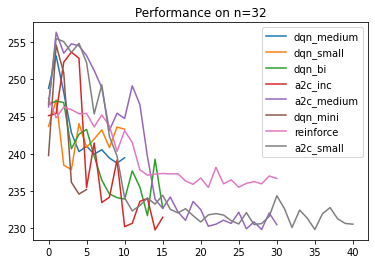

In [73]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "a2c_inc", "a2c_medium", "dqn_mini", "reinforce", "a2c_small"]:
    plt.plot(results[agent_name, "large"], label=agent_name)
plt.legend()
plt.title("Performance on n=32")

Text(0.5, 1.0, 'Performance on n=16')

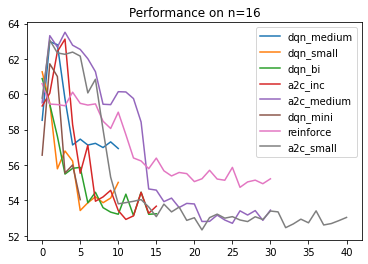

In [74]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "a2c_inc", "a2c_medium", "dqn_mini", "reinforce", "a2c_small"]:
    plt.plot(results[agent_name, "medium"], label=agent_name)
plt.legend()
plt.title("Performance on n=16")

Text(0.5, 1.0, 'Performance on n=8')

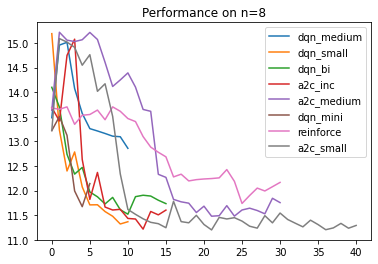

In [75]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "a2c_inc", "a2c_medium", "dqn_mini", "reinforce", "a2c_small"]:
    plt.plot(results[agent_name, "small"], label=agent_name)
plt.legend()
plt.title("Performance on n=8")

Text(0.5, 1.0, 'Performance on n=2')

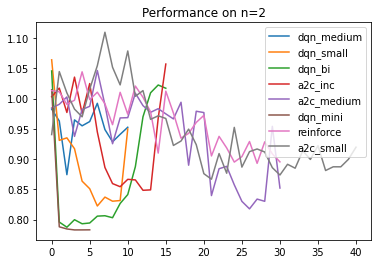

In [80]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "a2c_inc", "a2c_medium", "dqn_mini", "reinforce", "a2c_small"]:
    plt.plot(results[agent_name, "mini_lap"], label=agent_name)
plt.legend()
plt.title("Performance on n=2")

Text(0.5, 1.0, 'Performance on n=64')

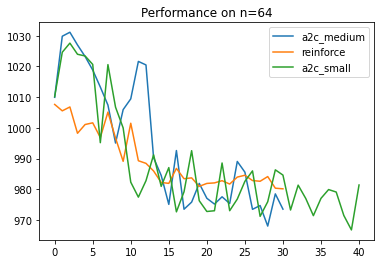

In [77]:
for agent_name in ["a2c_medium", "reinforce", "a2c_small"]:
    plt.plot(results[agent_name, "64"], label=agent_name)
plt.legend()
plt.title("Performance on n=64")

Text(0.5, 1.0, 'Performance on n=128')

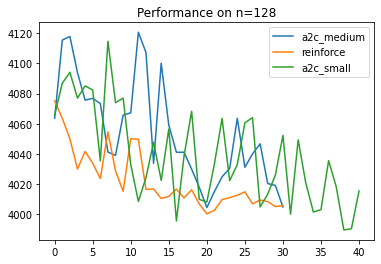

In [78]:
for agent_name in ["a2c_medium", "reinforce", "a2c_small"]:
    plt.plot(results[agent_name, "128"], label=agent_name)
plt.legend()
plt.title("Performance on n=128")